In [35]:
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature

In [ ]:


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.autolog()  # Or other tracking functions


# Model Keras LSTM

# Importation des libraires 

In [7]:
import numpy as np # linear algebraa
import pandas as pd #* data processing, CSV file I/O (e.g. pd.read_csv)
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

import os
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Import nltk package and download the stopwords
import nltk 
from nltk.corpus import stopwords

## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

from keras.preprocessing.text import Tokenizer

from keras.utils import pad_sequences

from sklearn.preprocessing import LabelEncoder

# Import various layers needed for the architecture from keras
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint


from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import pickle
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from nltk.stem import SnowballStemmer
import re

Segmentation Models: using `tf.keras` framework.


# Importation du dataset

In [3]:
dataset_path = "data/training.1600000.processed.noemoticon.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding = "ISO-8859-1" , names= ["target", "ids", "date", "flag", "user", "text"])

Open file: data/training.1600000.processed.noemoticon.csv


In [4]:
df = df.drop(['ids', 'date', 'flag', 'user'], axis=1)


In [5]:
df.tail(20)

,target,text
1599980,4,@myheartandmind jo jen by nemuselo zrovna tÃ© ...
1599981,4,Another Commenting Contest! [;: Yay!!! http:/...
1599982,4,@thrillmesoon i figured out how to see my twee...
1599983,4,"@oxhot theri tomorrow, drinking coffee, talkin..."
1599984,4,You heard it here first -- We're having a girl...
1599985,4,"if ur the lead singer in a band, beware fallin..."
1599986,4,@tarayqueen too much ads on my blog.
1599987,4,@La_r_a NEVEER I think that you both will get...
1599988,4,@Roy_Everitt ha- good job. that's right - we g...
1599989,4,@Ms_Hip_Hop im glad ur doing well


# Transformation de la donnée

In [6]:
label_to_target = {0:"Negative", 4:"Positive"}
def label_decoder(label):
     return label_to_target[label]
df.target = df.target.apply(lambda x: label_decoder(x))

On vérifie si les classes sont bien équilibré

<BarContainer object of 2 artists>

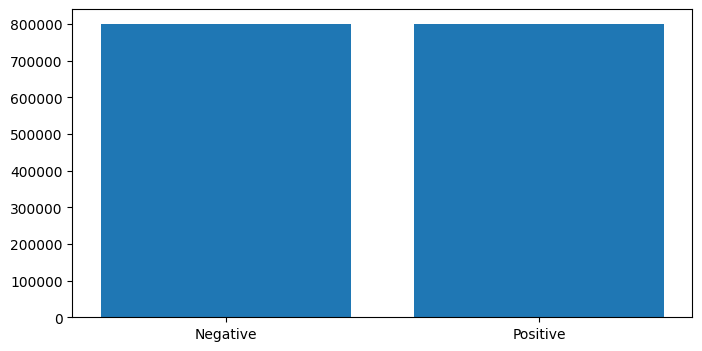

In [7]:
distribution = df.target.value_counts()
plt.figure(figsize=(8,4))
plt.bar(distribution.index, distribution.values)

on applique un filtre avec les stopwords qui vont pouvoir enlever les mots inutile pour le modèle

## Stopwords

In [11]:
nltk.download('stopwords')
# We filter out the english language stopwrds

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jupiter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stemmer 

Un stemmer, également appelé racinisateur, est un outil utilisé en traitement automatique du langage naturel pour réduire les mots à leur forme de base ou racine, appelée le "stem". Le processus de "stemming" consiste à retirer les affixes (préfixes et suffixes) des mots tout en conservant la partie centrale, qui représente la racine commune.

Le stemmer vise à regrouper les mots apparentés sous une même racine, ce qui facilite l'analyse textuelle en réduisant la dimensionnalité du vocabulaire et en mettant l'accent sur le sens plutôt que sur les variations morphologiques.

on établie un fonction pour nettoyer les tweets qui va utiliser le stemmer

In [12]:
stemmer = SnowballStemmer('english')

## Regex

In [9]:

text_cleaning_regex = "@S+|https?:S+|http?:S|[^A-Za-z0-9]+"

fonction qui va nettoyer le texte des tweets

In [17]:
def clean_tweets(text, stem=False):
    # Text passed to the regex equation
    text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
    # Empty list created to store final tokens
    tokens = []
    for token in text.split():
        # Check if the token is a stop word or not
        if token not in stop_words:
            if stem:
                # Passed to the snowball stemmer
                tokens.append(stemmer.stem(token))
            else:
                # Added to the list as it is
                tokens.append(token)
    return " ".join(tokens)

In [12]:
df.text = df.text.apply(lambda x: clean_tweets(x))

In [13]:
# Splitting the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2,random_state=16)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


## Tokenizer

In [14]:
tokenizer = Tokenizer()

In [15]:
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
print(word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 565660


pad_sequences est utilisé pour effectuer un rembourrage (padding) des séquences dans un ensemble de données. Dans le contexte du traitement du langage naturel, cela est couramment utilisé pour préparer des données textuelles avant de les utiliser dans un modèle de réseau neuronal.

In [17]:
# The tokens are converted into sequences and then passed to the pad_sequences() function
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),maxlen = 30)

In [18]:
labels = ['Negative', 'Positive']

encoder = LabelEncoder()
encoder.fit(train_data.target.to_list())
y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Word Embeding GLOVE

On applique le word Embeding GLOVE

In [19]:
embeddings_index = {}
# opening the downloaded glove embeddings file
f = open('data/glove.6B.300d.txt',encoding="utf8")
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [20]:
# creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, 300))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

In [21]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)

# Model

## Défintion du model - Training

In [22]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.5)

In [23]:
learning_rates = [0.01, 0.02, 0.03]

def create_model(lrs) : 
    
    # The Input layer 
    sequence_input = Input(shape=(30,), dtype='int32')
    # Inputs passed to the embedding layer
    embedding_sequences = embedding_layer(sequence_input)
    # dropout and conv layer 
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    # Passed on to the LSTM layer
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    # Passed on to activation layer to get final output
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs)

    model.compile(optimizer = Adam(learning_rate = lrs), loss='binary_crossentropy',metrics=['accuracy'])
    
    
    return model

model = create_model(lr_schedule)    

In [24]:
#callback 
ReduceLROnPlateau = ReduceLROnPlateau(factor = 0.1,min_lr = 0.01, monitor = 'val_loss',verbose = 1)

Entraînement du model 

In [25]:
history = model.fit(x_train, y_train, batch_size = 1024, epochs = 10,
                    validation_data = (x_test, y_test), callbacks = [ReduceLROnPlateau])

1250/1250 [==============================] - 610s 485ms/step - loss: 0.5223 - accuracy: 0.7394 - val_loss: 0.4868 - val_accuracy: 0.7632 - lr: 0.0092


2023/07/17 10:13:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001ECC9B5BCA0>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))


## History plot métriques du training

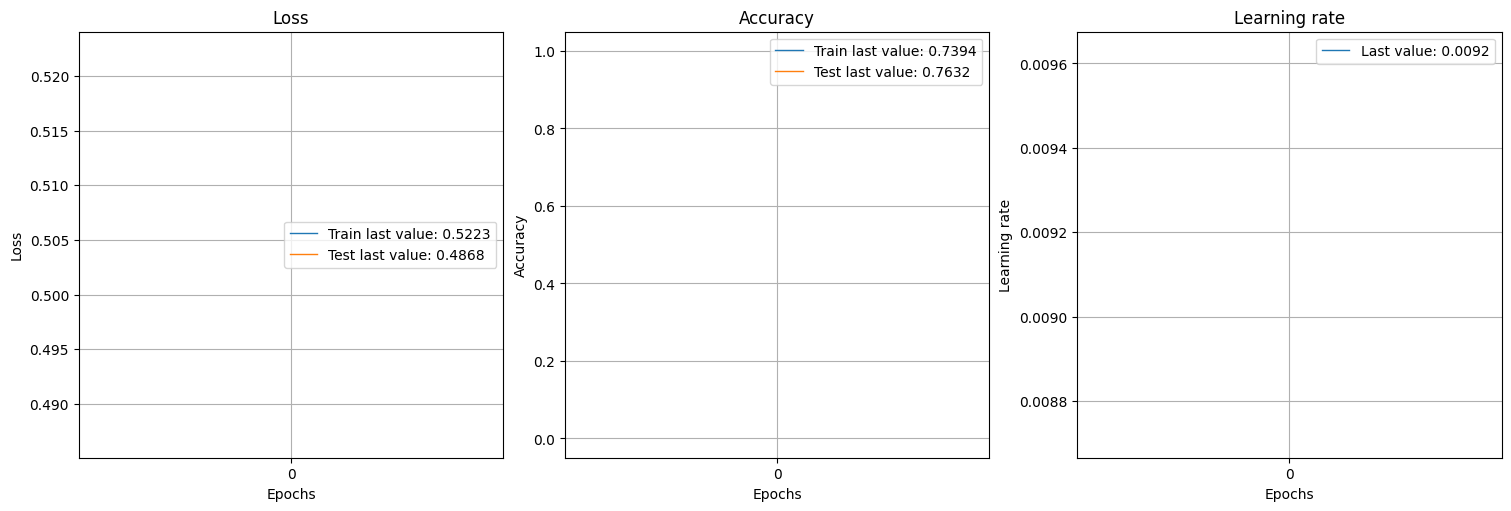

In [26]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

history = history
show_history(history)
plot_history(history, path="standard.png")
plt.close()

## Prédiction du sentiment des tweets

fonctions qui va prédire le sentiment d'un tweet avec le dataset de validation

In [33]:
def predict_tweet_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

def y_pred(score):
    return 1 if score>0.5 else 0

In [ ]:
scores = model.predict(x_test, verbose=1, batch_size=10000)
model_predictions = [predict_tweet_sentiment(score) for score in scores]
y_pred = [y_pred(score) for score in scores]

## Métriques

In [28]:
from sklearn.metrics import classification_report
print(classification_report(list(test_data.target), model_predictions))

              precision    recall  f1-score   support

    Negative       0.78      0.73      0.76    159809
    Positive       0.75      0.79      0.77    160191

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



## Sauvegarde des métriques 


In [29]:
recall = recall_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)

df = pd.DataFrame({'Nom du modèle': ['Modèle keras avec couche LSTM'], 'Recall': [recall], 'Precision': [precision], 'Accuracy': [accuracy]})

In [30]:
df

,Nom du modèle,Recall,Precision,Accuracy
0,Modèle keras avec couche LSTM,0.792554,0.748991,0.763191


In [31]:
#export de la donnée en csv 
df.to_csv('models_results/model_keras_lstm_results.csv')

## MLFOW sauvegarde des métriques et des paramètres

In [44]:
'''# Initialisation de MLflow
mlflow.start_run()
'''

# Enregistrement des métriques
mlflow.log_metric('accuracy', 1)
mlflow.log_metric('Recall', 21)
mlflow.log_metric('Precision', 14)
mlflow.log_param('loss', 'binary_crossentropy')
mlflow.log_param('opitmizer', Adam)
mlflow.log_param('learning rate', lr_schedule)

## Savegarde du model, model enregistrer avec Mlflow

In [50]:
#save models
pickle.dump(model, open('data/model_keras_LSTM.pkl', 'wb'))

#sauvegarde du model via mlflow
y_pred_array = np.array(y_pred)

signature = infer_signature(x_test, y_pred_array)
mlflow.keras.log_model(model, 'keras LSTM', signature = signature)

INFO:tensorflow:Assets written to: C:\Users\Jupiter\AppData\Local\Temp\tmpa2oqotst\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Jupiter\AppData\Local\Temp\tmpa2oqotst\model\data\model\assets
D:\anaconda3\envs\OPP7\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [51]:
# Arrêt de l'exécution deMLflow
mlflow.end_run()

# Test unitaire

In [2]:
import unittest

In [34]:
# Tests unitaires
def test_clean_tweets():
    # Cas de test avec stem=False
    input_text = "Hello! This is a sample tweet."
    expected_output = "hello sample tweet"
    assert clean_tweets(input_text) == expected_output

    # Cas de test avec stem=True
    input_text = "Running, runs"
    expected_output = "run run"
    assert clean_tweets(input_text, stem=True) == expected_output

    # Cas de test avec un texte vide
    input_text = ""
    expected_output = ""
    assert clean_tweets(input_text) == expected_output

    # Cas de test avec uniquement des stop words
    input_text = "the and is"
    expected_output = ""
    assert clean_tweets(input_text) == expected_output
    
    
def test_predict_tweet_sentiment():
    # Cas de test avec score > 0.5
    score = 0.8
    expected_output = "Positive"
    assert predict_tweet_sentiment(score) == expected_output

    # Cas de test avec score <= 0.5
    score = 0.3
    expected_output = "Negative"
    assert predict_tweet_sentiment(score) == expected_output

def test_y_pred():
    # Cas de test avec score > 0.5
    score = 0.8
    expected_output = 1
    assert y_pred(score) == expected_output

    # Cas de test avec score <= 0.5
    score = 0.3
    expected_output = 0
    assert y_pred(score) == expected_output



# Appel du test unitaire
test_clean_tweets()
test_predict_tweet_sentiment()
test_y_pred()

In [ ]:
# ajioute batch et epoch parmetre mlfow

In [ ]:
import mlflow
logged_model = 'runs:/ed0a2af655644b3f8572bea3c66aa100/keras LSTM'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(data))